In [1]:

#!pip install --user scikit-image

In [2]:
%matplotlib notebook
import os
import struct
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td 
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
from skimage import transform
import cv2

!rm nntools.py

!ln -s /datasets/ee285f-public/nntools.py
import nntools as nt

import Data
import build
import yolo2loss as loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'
data = Data.getdata(dataset_root_dir)
train_set, test_set = data

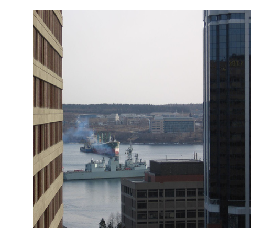

In [4]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

myimshow(train_set[100]['image'])

In [20]:
class Yolo_detector(build.Yolov2):
    def __init__(self):
        super(Yolo_detector, self).__init__()
        
    def criterion(self, y, d):
        return loss.loss(y, d[0], d[1])

In [22]:
net = Yolo_detector()
pretrained_net = build.load_pretrained_weights(net)

In [23]:
childs = list(net.children())
for i in range(len(childs)):
    for param in childs[i].parameters():
        if i < 38:
            param.requires_grad = False
        else:
            param.requires_grad = True
            
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([32, 3, 3, 3]) False
batchnorm1.weight torch.Size([32]) False
batchnorm1.bias torch.Size([32]) False
conv2.weight torch.Size([64, 32, 3, 3]) False
batchnorm2.weight torch.Size([64]) False
batchnorm2.bias torch.Size([64]) False
conv3.weight torch.Size([128, 64, 3, 3]) False
batchnorm3.weight torch.Size([128]) False
batchnorm3.bias torch.Size([128]) False
conv4.weight torch.Size([64, 128, 1, 1]) False
batchnorm4.weight torch.Size([64]) False
batchnorm4.bias torch.Size([64]) False
conv5.weight torch.Size([128, 64, 3, 3]) False
batchnorm5.weight torch.Size([128]) False
batchnorm5.bias torch.Size([128]) False
conv6.weight torch.Size([256, 128, 3, 3]) False
batchnorm6.weight torch.Size([256]) False
batchnorm6.bias torch.Size([256]) False
conv7.weight torch.Size([128, 256, 1, 1]) False
batchnorm7.weight torch.Size([128]) False
batchnorm7.bias torch.Size([128]) False
conv8.weight torch.Size([256, 128, 3, 3]) False
batchnorm8.weight torch.Size([256]) False
batchnorm8.bia

In [26]:
class YOLOStatsManager(nt.StatsManager):
    def __init__(self):
        super(YOLOStatsManager, self).__init__()

    def init(self):
        super(YOLOStatsManager, self).init()
        #self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d): 
        super(YOLOStatsManager, self).accumulate(loss, x, y, d)
#         _, l = torch.max(y, 1)
#         self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(YOLOStatsManager, self).summarize() 
#         accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss}

In [29]:
!rm -r yolo_voc1

lr = 1e-3
net = Yolo_detector()
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YOLOStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, output_dir="yolo_voc1", perform_validation_during_training=False)

In [42]:
aa = td.DataLoader(train_set, batch_size=4, shuffle=True,
                                     drop_last=True, pin_memory=True)
for a in aa:
    print(a)

{'image': tensor([[[[ 0.3647,  0.3647,  0.3647,  ...,  0.4275,  0.4196,  0.4196],
          [ 0.3647,  0.3647,  0.3725,  ...,  0.4275,  0.4275,  0.4275],
          [ 0.3647,  0.3725,  0.3647,  ...,  0.4196,  0.4196,  0.4196],
          ...,
          [ 0.2627,  0.2863,  0.3098,  ..., -0.8353, -0.8275, -0.8196],
          [ 0.3176,  0.3176,  0.3020,  ..., -0.8275, -0.8275, -0.8275],
          [ 0.3098,  0.3333,  0.3255,  ..., -0.8196, -0.8118, -0.8196]],

         [[ 0.5529,  0.5529,  0.5529,  ...,  0.6235,  0.6157,  0.6157],
          [ 0.5529,  0.5529,  0.5608,  ...,  0.6235,  0.6235,  0.6235],
          [ 0.5529,  0.5608,  0.5608,  ...,  0.6157,  0.6157,  0.6157],
          ...,
          [ 0.0588,  0.0745,  0.1059,  ..., -0.5922, -0.5922, -0.6000],
          [ 0.1059,  0.1059,  0.0980,  ..., -0.5922, -0.6000, -0.6157],
          [ 0.0980,  0.1216,  0.1216,  ..., -0.5922, -0.6000, -0.6078]],

         [[ 0.8353,  0.8353,  0.8353,  ...,  0.8588,  0.8510,  0.8510],
          [ 0.8353, 

{'image': tensor([[[[-0.8118, -0.8353, -0.7725,  ..., -0.6784, -0.6941, -0.7647],
          [-0.8667, -0.8510, -0.8118,  ..., -0.6863, -0.7176, -0.8196],
          [-0.8667, -0.8588, -0.8824,  ..., -0.7490, -0.7569, -0.8118],
          ...,
          [-0.8196, -0.8275, -0.8431,  ...,  0.5373,  0.5373,  0.5294],
          [-0.8353, -0.8431, -0.8275,  ...,  0.5294,  0.5216,  0.5137],
          [-0.8745, -0.8745, -0.7882,  ...,  0.4824,  0.4667,  0.4667]],

         [[-0.6863, -0.7412, -0.7098,  ..., -0.5608, -0.5765, -0.6392],
          [-0.7647, -0.7647, -0.7569,  ..., -0.5843, -0.6157, -0.7176],
          [-0.8039, -0.7961, -0.8275,  ..., -0.6392, -0.6471, -0.7020],
          ...,
          [-0.8196, -0.8353, -0.8667,  ...,  0.5216,  0.5216,  0.5137],
          [-0.8196, -0.8510, -0.8588,  ...,  0.5137,  0.5059,  0.4980],
          [-0.8510, -0.8824, -0.8353,  ...,  0.4667,  0.4510,  0.4510]],

         [[-0.7882, -0.8353, -0.7882,  ..., -0.6157, -0.6471, -0.7176],
          [-0.8275, 

KeyboardInterrupt: 

Start/Continue training from epoch 0


ValueError: too many values to unpack (expected 2)

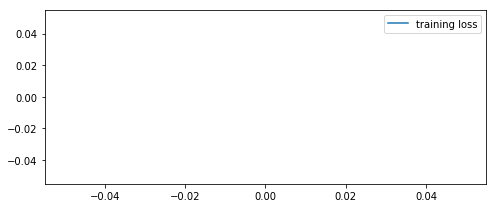

In [33]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k]['loss'] for k in range(exp.epoch)], label="training loss")
    plt.tight_layout()
    fig.canvas.draw()
    axes.legend()

fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))